In [81]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import pmdarima as pm
import prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


## Main Objective

In this project I want to forecast the daily minimum temperatures of a city using some historical (10 years of data). 

## Load data and Description

This is a 10-years period historical data sampled on daily bases starting from 1981-01-01 to 1990-12-31 (as is printed using `info()` method on the pandas dataframe). The steps for the data preprosing towards modeling is as follows:

* Set the desired frequency using the `asfreq("D")` to daily. By doing this we can identify the missing data

* Identify the missing data and fill them with forward fill method, `ffill()`.

* Run sequence plots to visualise the data for stationarity as stationary data are easier to model.

* Check for stationary using autocorrelation plots, Q-Q plot, test statistics like the Augmented Dickey Fuler test, checked for constant mean and variance across the data and finnaly signal decomposition

* Apply some transformation if neccessary to make the signal stationary

* Create forecast model once the signal has been understood.

* Make inferences

In [57]:
df_temp = pd.read_csv(
    "daily-min-temperatures.csv", header=0, parse_dates=[0], index_col=0
)

print(
    "Head:\n",
    df_temp.head(),
)
print(
    "\n describe:\n",
    df_temp.describe(),
)
print(
    "\n \t",
    df_temp.info(),
)

Head:
             Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

 describe:
               Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB

 	 None


### Set Desired Frequency and fill in the missing values

In [58]:
# frequency is daily and it is not set

print(df_temp.index)

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)


In [59]:
# setting frequency to daily and accounting for missing values

df_temp = df_temp.asfreq("D")

print(df_temp.index)

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')


In [60]:
# two missing values

df_temp.isna().sum()

Temp    2
dtype: int64

In [61]:
# filling missing values with forward fill

df_temp = df_temp.ffill()

df_temp.isna().sum()  # two missing values

Temp    0
dtype: int64

## Visualizing data to check for stationarity

* There is clear seasonality which renders the data non-stationary

* From and the monthly and quarterly seasonal plot, we see clearly some seasonaly in the data

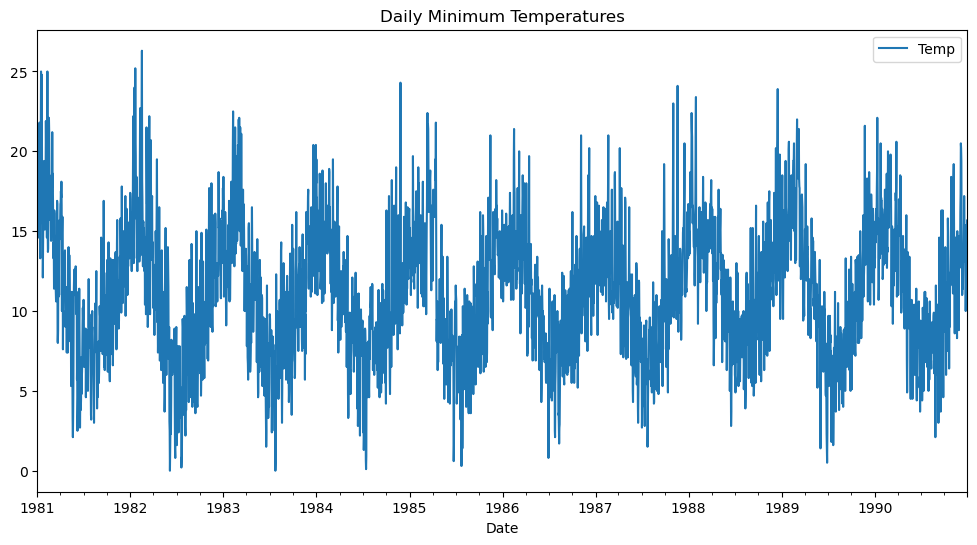

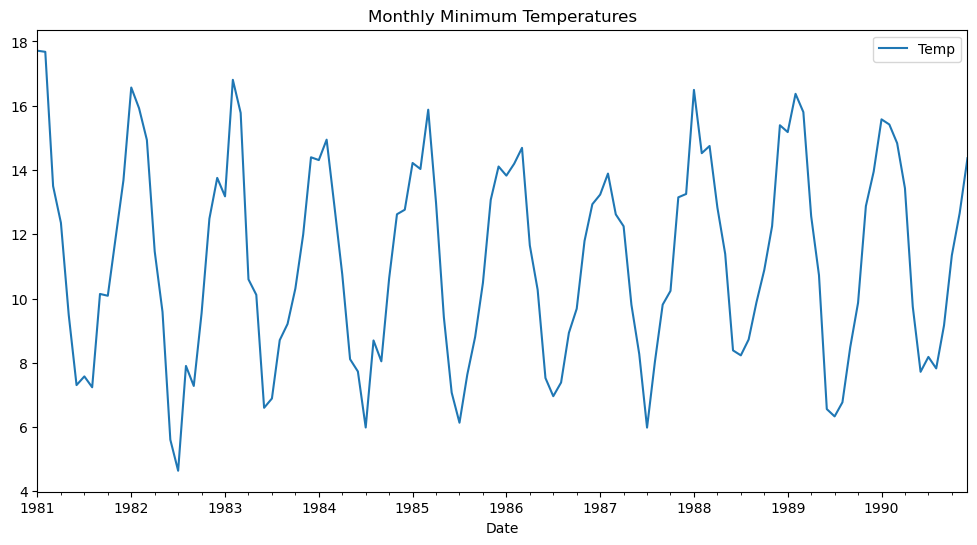

In [62]:
df_temp.plot(figsize=(12, 6), title="Daily Minimum Temperatures")
df_temp.resample("M").mean().plot(figsize=(12, 6), title="Monthly Minimum Temperatures")

plt.show()

## Seasonality plots


Monthly Data Seasonal Plot


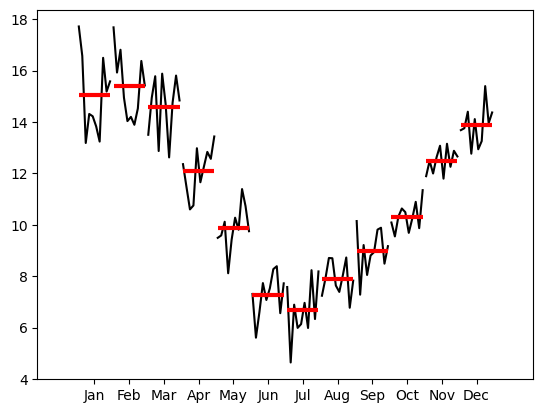

In [63]:
print("\nMonthly Data Seasonal Plot")
m_plot = month_plot(df_temp.Temp.resample("M").mean())


Quarterly Data Seasonal Plot


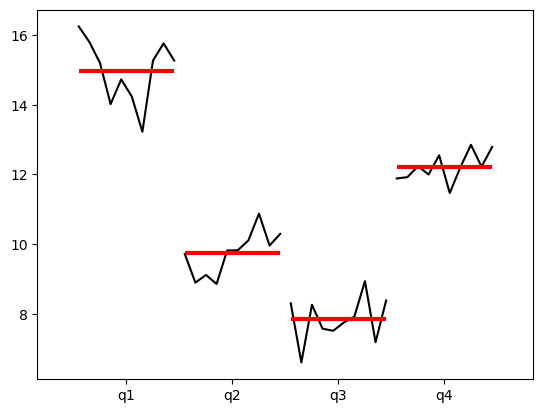

In [64]:
print("\nQuarterly Data Seasonal Plot")
q_plot = quarter_plot(df_temp.Temp.resample("Q").mean())

From the auto corrlation plot below, we see a seasonality of 365 days

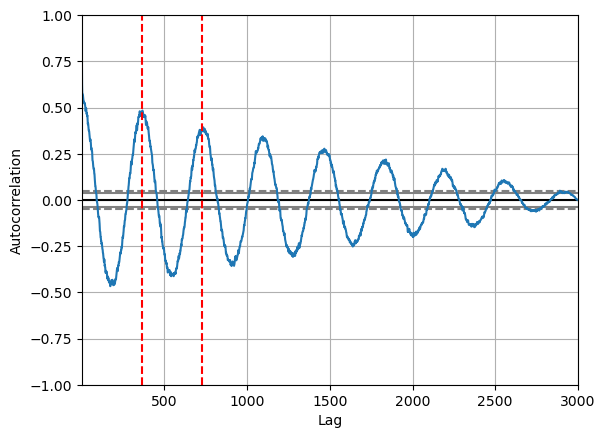

In [102]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_temp.Temp[:3000])
plt.axvline(365, color="r", linestyle="--")
plt.axvline(365 * 2, color="r", linestyle="--")

## Q-Q plot
If the data fits well to a Gaussian distribution, it gives an indication that the the mean and variance are constant. It is preferrable to use the q-q plot instead of a histogram as histograms can be sometimes be misleading with the wrong choice of bins.

### White Noise
White noise fit the criteria below of what we expectedfrom a stationary data:
* Const mean
* const variance
* no autocorrelations

The data does not completely fit a Gaussian distribution as you will expect.

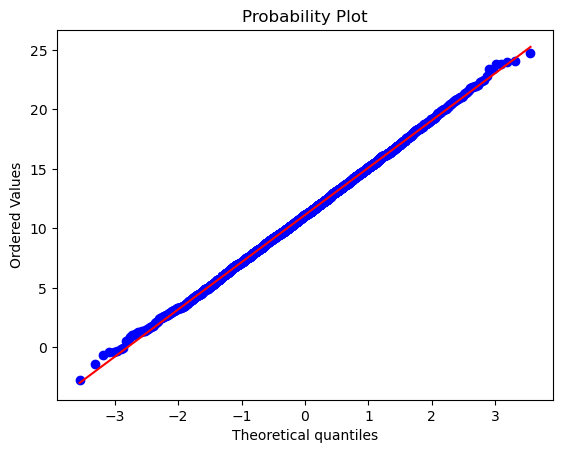

In [65]:
# white noise
np.random.seed(2603)
stats.probplot(
    np.random.normal(df_temp.Temp.mean(),
                     df_temp.Temp.std(), len(df_temp.Temp)),
    plot=plt,
)
plt.show()

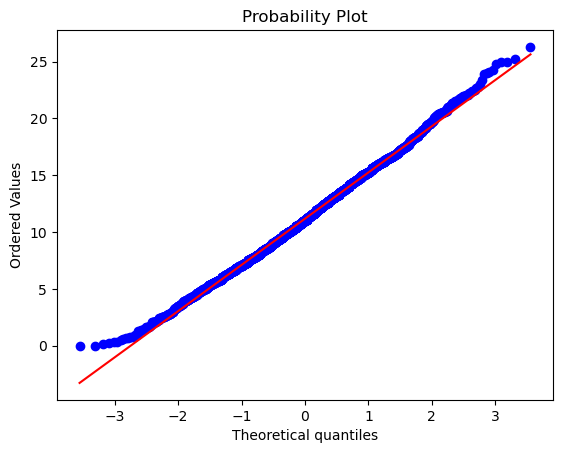

In [66]:
# this is what we expect from time series data not to be normally distributed
stats.probplot(df_temp.Temp, plot=plt)
plt.show()

### Decomposition of signal

This signal appears to additive as the magnitude of the signal does not increase with trend over time. The trend is constantly changing and there is clearly an anunual seasonality in the data. By decomposing the time-series we see the trend and seasonality. The residual appeart stationary

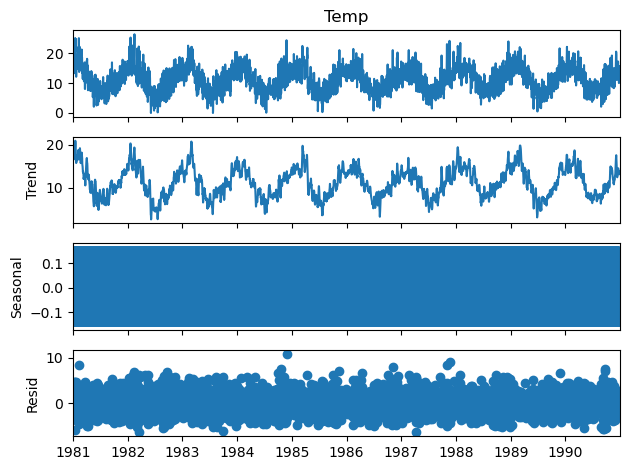

In [67]:
s_dec_additive = seasonal_decompose(df_temp.Temp, model="additive")

s_dec_additive.plot()
plt.show()

## Test of stationarity conditions - complementary check

* Constant mean (condition not met and points the existence of some trend)
* Constant variance (condition not met)
* Weak autocorrelation (we have strong correlations up to last 50 days)


All these point to the fact that the data is not stationary

/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


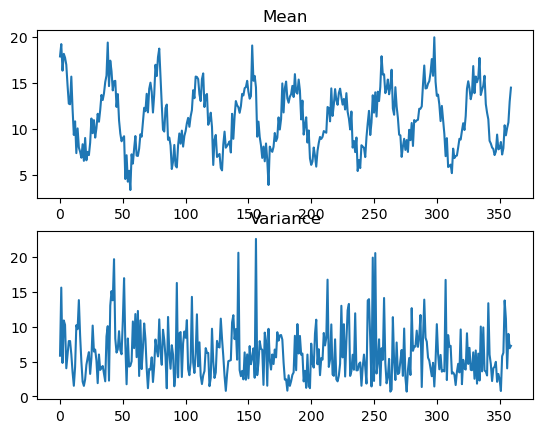

In [68]:
split = np.split(df_temp.Temp[:3600], indices_or_sections=360, axis=0)
# split = np.split(df_temp.residual[:3600], indices_or_sections=360, axis=0)

mean = [section.mean() for section in split]
var = [section.var() for section in split]

plt.subplot(2, 1, 1)
plt.plot(mean)
plt.title("Mean")

plt.subplot(2, 1, 2)
plt.plot(var)
plt.title("Variance")
plt.show()

## Differencing

Applied some differencing to reduce the seasonality

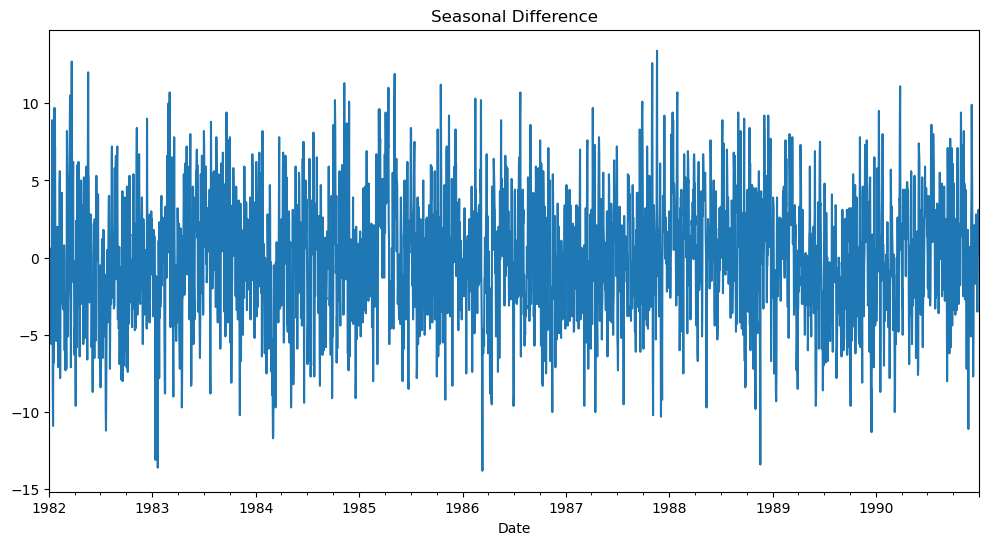

In [152]:
# df_temp["log_temp"] = np.log(df_temp.Temp)

df_temp["residual"] = s_dec_additive.resid

df_temp["lag_365"] = df_temp.Temp.shift(365)

df_temp["seasonal_difference"] = df_temp.Temp - \
    df_temp.lag_365  # df_temp.Temp.diff(2)  #

# df_temp["log_temp"].plot(figsize=(12, 6), title="Log of Daily Minimum Temperatures")
# plt.show()

df_temp["seasonal_difference"].dropna().plot(
    figsize=(12, 6), title="Seasonal Difference"
)
plt.show()

#### Auto-Correlation and insight

WIthout differencing, a positive autocorrelation up to a higher number of lags is observed, hence a higher order differencing is needed (Duke ARIMA Guidelines). By differencing there is an exponential decay and so the choice of two lags in our MA model. Predictions with MA model therefore depends on the last three days

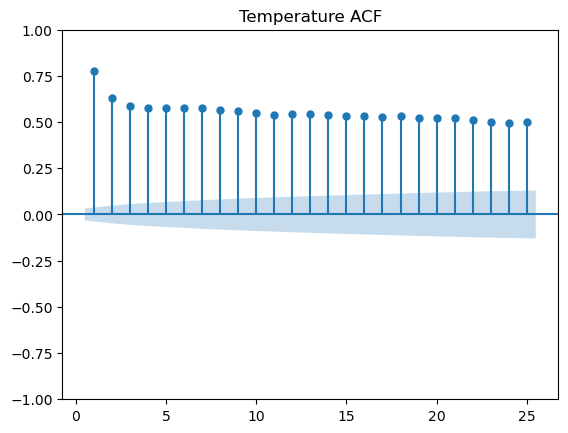

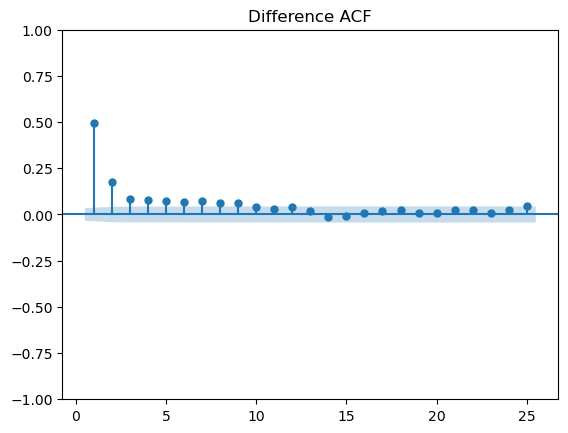

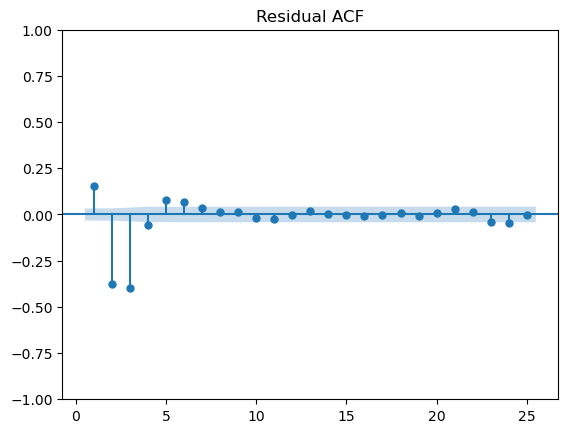

In [153]:
plot_acf(df_temp.Temp, lags=25, zero=False, title="Temperature ACF")
plt.show()
plot_acf(
    df_temp.seasonal_difference.dropna(), lags=25, zero=False, title="Difference ACF"
)
plt.show()

plot_acf(df_temp.residual.dropna(), lags=25, zero=False, title="Residual ACF")
plt.show()

#### Partial Auto-Correlation and Insight

From this plot, the we can safely use the two lags in an AR model. This means that the future forecast depends on the last two days.

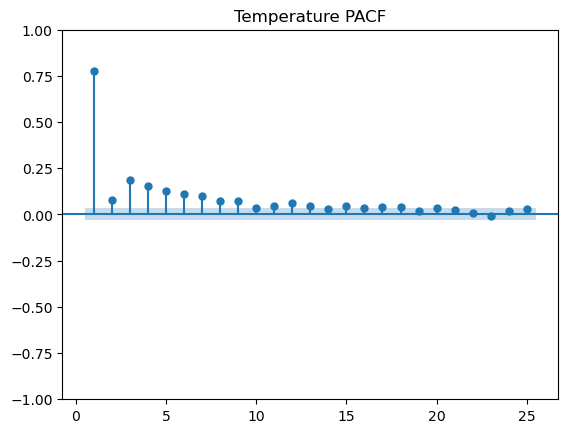

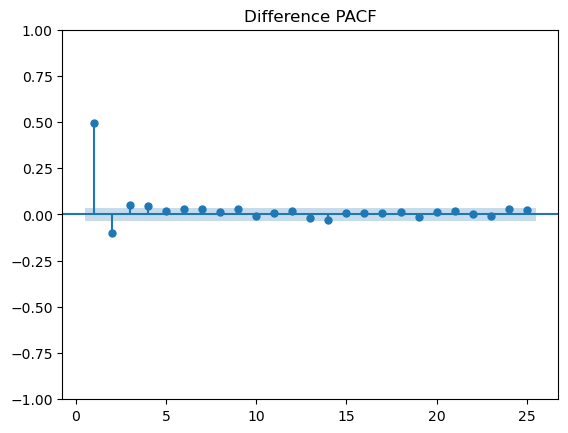

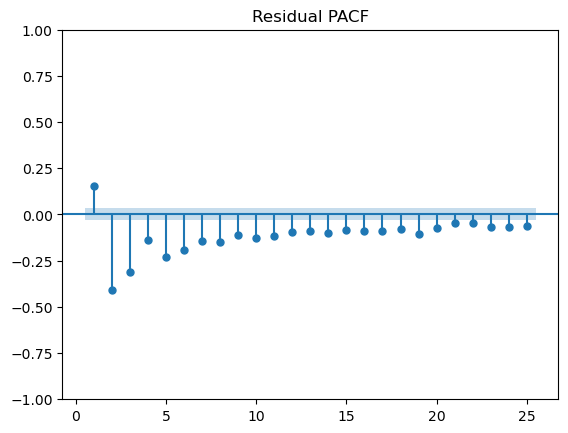

In [154]:
plot_pacf(df_temp.Temp, lags=25, zero=False, title="Temperature PACF")
plt.show()
plot_pacf(
    df_temp.seasonal_difference.dropna(), lags=25, zero=False, title="Difference PACF"
)

plt.show()

plot_pacf(df_temp.residual.dropna(), lags=25,
          zero=False, title="Residual PACF")
plt.show()

## Statistical test for stationarity - Augmented Dickey Fuller test

P-value ≤ significance level
Test statistic ≤ critical value
If the p-value is less than or equal to the significance level or if the test statistic is less than or equal to the critical value, the decision is to reject the null hypothesis. Because the data provide evidence that the data are stationary, the recommendation of the analysis is to proceed without differencing.

P-value > significance level
Test statistic > critical value
If the p-value is greater than the significance level or if the test statistic is greater than the critical value, the decision is to fail to reject the null hypothesis. Because the data do not provide evidence that the data are stationary, the recommendation of the analyis is to determine whether differencing makes the mean of the data stationary.


For this work, the p-value is very less than the significance level of 0.05 and the ADF test statistics is less than any of the critical values and hence we can reject the null hypothesis (non stationarity) and take that the series as stationary.The test result is misleading as visualization paints a different picture.

In [69]:

adfuller(df_temp.Temp),

((-4.440933664385148,
  0.0002510472415292601,
  20,
  3631,
  {'1%': -3.4321522387754775,
   '5%': -2.862336328589075,
   '10%': -2.567193897993964},
  16651.240027625234),)

In [75]:
adfuller(df_temp.diff(1).dropna().values.flatten()), adfuller(
    df_temp.seasonal_difference.dropna().values.flatten())

((-23.90183507708432,
  0.0,
  38,
  9819,
  {'1%': -3.4310161585056123,
   '5%': -2.861834401835228,
   '10%': -2.5669267049677167},
  47020.82581454067),
 (-17.575090919921337,
  4.033390332119365e-30,
  6,
  3280,
  {'1%': -3.4323452515445956,
   '5%': -2.862421583712013,
   '10%': -2.5672392854885486},
  17157.79969789907))

## Split data to train and test set

No shuffling is done for time-series data

In [77]:
train, test = df_temp.Temp[:-7], df_temp.Temp[-7:]

## Model Selection based on Insight

Since the time-series is non-stationary, we will not use the ARMA models as they rely on stationarity. We use SARIMA model as the series has trend and seasonality. Based on the insight from the autocorrelation plots and differenicing we set out hyperparameters to be: 
$p=2, d=0, q=3$

/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


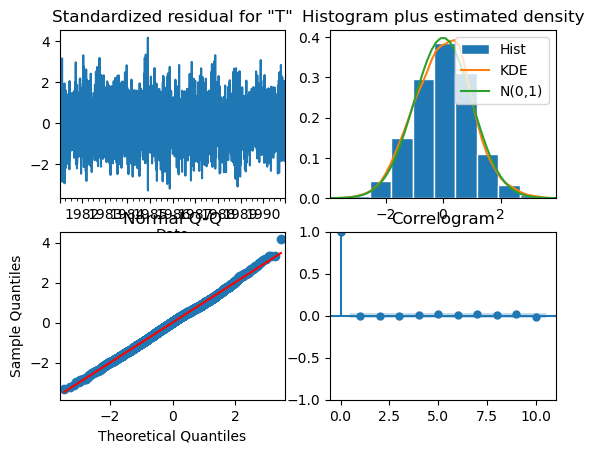

In [140]:
# model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 365))

model = ARIMA(train, order=(2, 2, 3))

result = model.fit()

result.plot_diagnostics()
plt.show()

In [141]:
pred = result.predict(start=len(train), end=len(
    train) + len(test) - 1, dynamic=False)

## Evaluating model

Here, several models were explored like the simple averaging, simple moving average, exponential smoothenings a nd the ARIMA model.

Since there is trend and seasonality, I expected Triple exponential to do a better job than the other exponential smoothing techniques. To evaluate the models, I used the mean squared error (MSE) and the model with the least MSE is the best performing model which in this case is the simple moving average followed bby the ARIMA model which does a good job in somehow modeling the trend of the series

In [142]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import Holt

# simple average
predsa = [train.mean()] * len(test)

# moving average
predma = [train.rolling(window=7).mean().iloc[-1]] * len(test)

# single exponential smoothing
predses = SimpleExpSmoothing(train).fit(optimized=True).forecast(len(test))

# double exponential smoothing
preddes = Holt(train).fit(optimized=True).forecast(len(test))

# tirple exponential smoothing
predtes = (
    ExponentialSmoothing(
        train, trend="additive", seasonal="additive", seasonal_periods=365
    )
    .fit(optimized=True)
    .forecast(len(test))
)

In [143]:
print("Simple Average MSE:", mean_squared_error(test, predsa))
print("Moving Average MSE:", mean_squared_error(test, predma))
print("Single Exponential Smoothing MSE:", mean_squared_error(test, predses))
print("Double Exponential Smoothing MSE:", mean_squared_error(test, preddes))
print("Triple Exponential Smoothing MSE:", mean_squared_error(test, predtes))
print("ARIMA MSE: ", mean_squared_error(test, pred))

# print("AutoReg MSE:", mean_squared_error(test, pred))

Simple Average MSE: 8.25550478523755
Moving Average MSE: 0.8293877551020403
Single Exponential Smoothing MSE: 3.9475351143245283
Double Exponential Smoothing MSE: 6.561415199453889
Triple Exponential Smoothing MSE: 1.5315489236409057
ARIMA MSE:  1.0206077508314007


In [144]:
dt = {}
dt["test"] = test.values
dt["pred"] = pred.values
dt["predsa"] = predsa
dt["predma"] = predma
dt["predses"] = predses
dt["preddes"] = preddes
dt["predtes"] = predtes

dt = pd.DataFrame(dt)
dt.index = test.index

dt.head()

,test,pred,predsa,predma,predses,preddes,predtes
Date,,,,,,,
1990-12-25,12.9,12.042789,11.17476,13.928571,12.133941,11.577662,12.886475
1990-12-26,14.6,13.622184,11.17476,13.928571,12.133941,11.554722,11.856779
1990-12-27,14.0,14.204463,11.17476,13.928571,12.133941,11.531783,12.417709
1990-12-28,13.6,14.403447,11.17476,13.928571,12.133941,11.508843,13.300312
1990-12-29,13.5,14.481490,11.17476,13.928571,12.133941,11.485904,13.436989


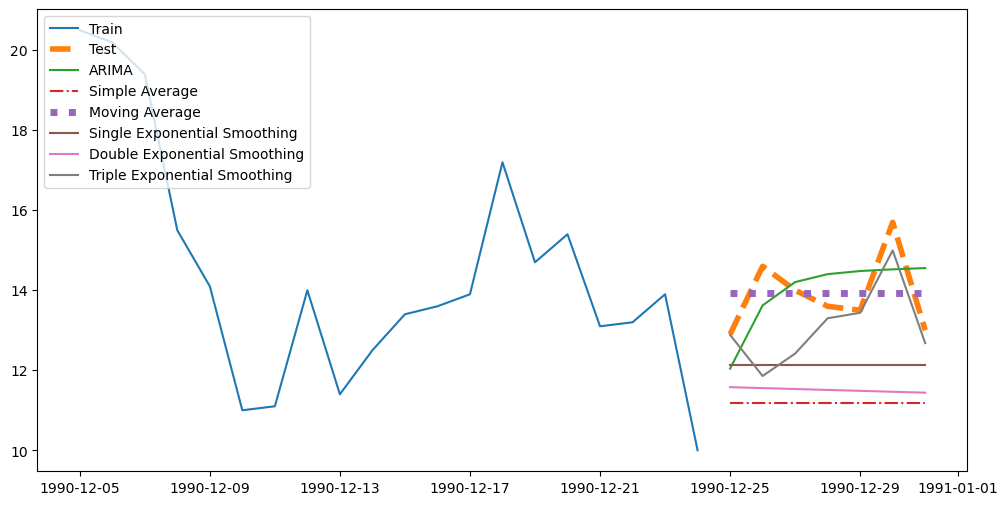

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(train[-20:], label="Train")
plt.plot(dt.test, label="Test", ls="--", lw=4)
plt.plot(dt.pred, label="ARIMA")
plt.plot(dt.predsa, label="Simple Average", ls="-.")
plt.plot(dt.predma, label="Moving Average", ls=":", lw=5)
plt.plot(dt.predses, label="Single Exponential Smoothing")  # SES
plt.plot(dt.preddes, label="Double Exponential Smoothing")  # DES
plt.plot(dt.predtes, label="Triple Exponential Smoothing")  # TES
plt.legend(loc="upper left")
plt.show()

## Future Steps

* Perform a grid search to optimize the hyperparameters for the ARIMA model
* Also use the SARIMA model
* Rethink the possibility of performing some log transformation to reduce the range of the variance across the series.